In [1]:
#Brker CNN arkitektur kombinert med PyTorch 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

#other libraries
# from tqdm import tqdm
# import time
# import random
import os
import sys
from pathlib import Path
import h5py

#torch specific
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split
import wandb

c:\Users\47472\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
module_path = str(Path.cwd().parents[0].parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "bh" / "BH_n5_M8_res50_10000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "sph" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_10000_events.h5")

In [4]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [5]:
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [6]:
np.shape(dataArray)

(20000, 50, 50, 3)

In [7]:
labelsArray = np.concatenate((np.zeros(10_000),np.ones(10_000)),axis=0)

In [8]:
np.shape(labelsArray)

(20000,)

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [10]:
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [11]:
trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [12]:
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [13]:
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

In [14]:
class LinearModel(nn.Module):
    def __init__(self, resolution, num_classes, stride=1):

        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(3, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 2)
        


    def forward(self, x:Tensor):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [15]:
class ConvModel(nn.Module):
    def __init__(self):

        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=9, out_channels=27, kernel_size=3, padding=0)

        self.fc1 = nn.Linear(23*23*27, 128)
        self.fc2 = nn.Linear(128,2)


    def forward(self, x:Tensor):
        x = self.conv1(x)
        x = F.relu(x) #to activate function above

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x,2)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
 
        return x

In [16]:
linearModel = LinearModel(50*50*3, 2)

In [17]:
convModel = ConvModel() 

In [18]:
trainData.shape

torch.Size([15000, 50, 50, 3])

In [19]:
trainFlipped = trainData.permute(0,3,1,2)

In [20]:
trainFlipped.shape

torch.Size([15000, 3, 50, 50])

In [21]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(convModel.parameters(), lr=learning_rate)

In [22]:
trainLabels = trainLabels.type(torch.LongTensor)

In [23]:
import random

In [24]:
#Weights and biases set up
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "epochs": 10,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 591291 (g13hvl2023). Use `wandb login --relogin` to force relogin


In [25]:
wandb.watch(convModel, criterion, log='all', log_freq=100)

num_epochs = wandb.config['epochs']
learning_rate = wandb.config['learning_rate']

convModel.train()
for epoch in range(num_epochs):

    runningLoss = 0.0
    correct = 0
    for i, data in enumerate(trainLoader):
        inputs, labels = data

        optimizer.zero_grad()
        output = convModel(inputs.permute(0,3,1,2))

        loss = criterion(output, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()

        correct += torch.max(torch.exp(output), 1)[1] == labels
        
        runningLoss += loss.item()
    
    accuracy = correct / i
    epochLoss = runningLoss/len(bhArray)
    wandb.log({"epoch_loss":epochLoss, "accuracy": accuracy})

wandb.finish()

accuracy,▁▃▄▅▆▇▇███
epoch_loss,█▆▅▄▃▂▂▂▁▁
accuracy,49.83333
epoch_loss,0.00052


In [29]:
convModel.eval()

ConvModel(
  (conv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(9, 27, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=14283, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [79]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
y_pred = []
y_true = []
for inputs, labels in testLoader:

        output = convModel(inputs.permute(0,3,1,2)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.numpy()
        y_true.extend(labels) # Save Truth
        classes = (0,1)


AttributeError: 'NoneType' object has no attribute '_log'

[[1914  578]
 [ 446 2012]]


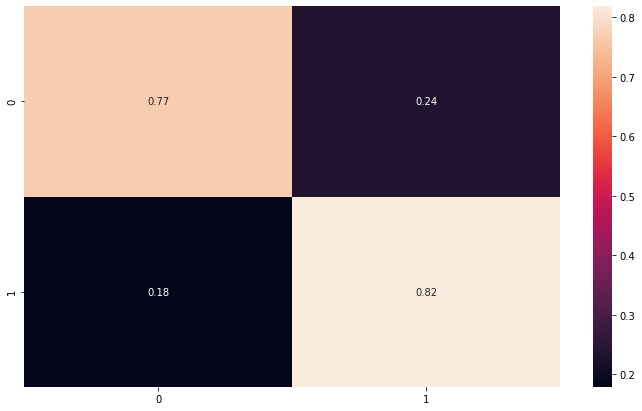

In [80]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
print(cf_matrix)